<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/beam-data/cv-intro/blob/master/notebooks/inference-tf2-dlcp.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/beam-data/cv-intro/blob/master/notebooks/inference-tf2-dlcp.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td><td>
  <a target="_blank"  href="http://beamdata.ca/">
    <img width=128px src="https://weclouddata.com/wp-content/uploads/2019/06/logo-w@3x.png" /></a>
</td></table>

#Tensorflow Object Detection API inference

Alright let's take a look at both the Tesnorflow 2 Object Detection API in conjunction with various types of incoming data.

- A folder full of pre-snapped images
- Images snapped on the fly using our webcam.
- Videos snapped on the fly using our webcam.

Not only can we grab inference and write to an image, or even frames of a video, but we'll take things a little further and take a look at what how to write those results to csv ready for analysis or even to propagate for training with a less computationally expensive architecture.

Before we go further however let's do some housekeeping and install tf odapi

##installation

In [ ]:
!from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content

import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2921, done.
remote: Counting objects: 100% (2921/2921), done.
remote: Compressing objects: 100% (2449/2449), done.
remote: Total 2921 (delta 742), reused 1273 (delta 434), pack-reused 0
Receiving objects: 100% (2921/2921), 32.97 MiB | 30.78 MiB/s, done.
Resolving deltas: 100% (742/742), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

#Test your setup!

Alright that's it! Let's go ahead ang grab a bunch of libraries we'll discus as we go including a range of utilities available to us within Tensorflow Object Detection API, serving as a Pillow wrapper. 

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

Now let's check everything installed ok by running the model builder demo:

In [ ]:
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

#Sample images

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def download_images():
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/test_images/'
    filenames = ['image1.jpg', 'image2.jpg']
    image_paths = []
    for filename in filenames:
        image_path = tf.keras.utils.get_file(fname=filename,
                                            origin=base_url + filename,
                                            untar=False)
        image_path = pathlib.Path(image_path)
        image_paths.append(str(image_path))
    return image_paths

IMAGE_PATHS = download_images()

1425408/1415684 [==============================] - 0s 0us/step


#Our own data

Alright, let's take a look at what we can do with different data sources. I've provided you all with a folder full of images of various scenes I took with a little robot. Go ahead and change the path below to correspond to the path you mounted your shared folder in google drive

In [ ]:
import glob

images =  glob.glob('/content/drive/MyDrive/testing_ground/capstone/pictures/*.jpg')

In [ ]:
images

Great! N ow let's go ahead and run both javascript cells below to give us notht he ability to record a video via out webcams as well as collecting snapshots should we wish.

Once you've run those cells simply go ahead and begin recording.

In [ ]:
#@title webcam frame - run this cell

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
#@title webcam video - run this cell

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def record_video(filename='video.mp4'):

  # This function uses the take_photo() function provided by the Colab team as a  
  # starting point, along with a bunch of stuff from Stack overflow, and some sample code 
  # from: https://developer.mozilla.org/enUS/docs/Web/API/MediaStream_Recording_API

  js = Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      capture.textContent = "Start Recording";
      capture.style.background = "green";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);
      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();

      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
      return btoa(binaryString);
    }
    """)
  try:
    display(js)
    data = eval_js('recordVideo({})')
    binary = b64decode(data)
    with open(filename, "wb") as video_file:
      video_file.write(binary)
    print(
        f"Finished recording video. Saved binary under filename in current working directory: {filename}"
    )
  except Exception as err:
      # In case any exceptions arise
      print(str(err))
  return filename

In [ ]:
# Run the function, get the video path as saved in your notebook, and play it back here.
from IPython.display import HTML
from base64 import b64encode

video_width = 640

video_path = record_video()
video_file = open(video_path, "r+b").read()

video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

<IPython.core.display.Javascript object>

Finished recording video. Saved binary under filename in current working directory: video.mp4


#Challenge

Excellent! Alright, now we can do somthing similar with ouimages excpt this time let's give each of our frames a unique timstamp. Any ideas how?

In [ ]:
#your code here

2021-09-20-18-09-10


Great! Now simply plug your timestamp in with an f-string and away you go. In this case, in order to verify a few scenarios let's go ahead and grab a few shots.

In [ ]:
import os
import shutil

if not os.path.isdir('cam_images'):
  os.makedirs('cam_images')
else:
  shutil.rmtree('cam_images')

<IPython.core.display.Javascript object>

Saved to cam_images/photo-2021-09-20-18-09-29.jpg


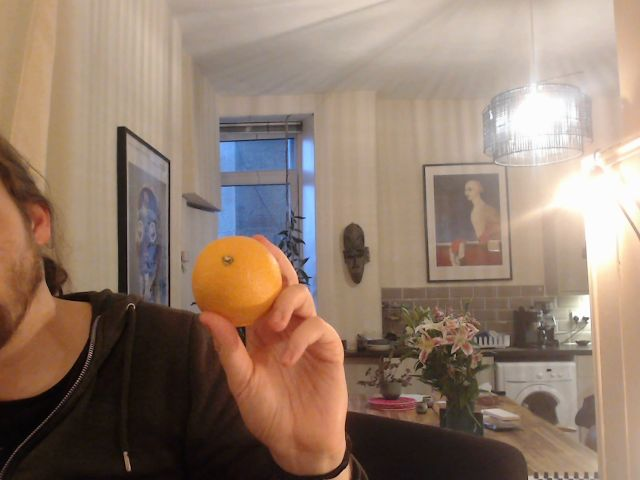

In [ ]:
from IPython.display import Image

dt = datetime.now()
pic = 'cam_images/photo-{0}.jpg'.format(dt.strftime('%Y-%m-%d-%H-%M-%S'))


try:
  filename = take_photo(filename = pic)
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

#Model Zoo

Check out the model zoo landing [page](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) for a full list of available pretrained models. I've gone ahead and provided a few for you with the dropdown below, feel free to plugin a few extras shoudl you wish! 

- Simply run the cell below after making your selection to grab a pretrained checkpoint.
- Second of all, run the next few cells to grab the corresponding coco dataset label map, load, verify, and pickle for use later.  

###Download and load

In [ ]:
# Download and extract model

import tensorflow as tf
models = 'efficientdet_d7_coco17_tpu-32' #@param ['ssd_resnet50_v1_fpn_640x640_coco17_tpu-8', 'efficientdet_d7_coco17_tpu-32', 'efficientdet_d3_coco17_tpu-32','ssd_resnet50_v1_fpn_640x640_coco17_tpu-8', 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'] 

def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = models + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
PATH_TO_MODEL_DIR = download_model(models, MODEL_DATE)

394485760/394474998 [==============================] - 2s 0us/step


In [ ]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"
#PATH_TO_SAVED_MODEL = '/content/TFTRT_FP16'

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

###Grab labels

In [ ]:
# Download labels file#
import pathlib
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

16384/5056 [=================================================================================================] - 0s 0us/step


In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [ ]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [ ]:
#save for later
import pickle 

path = '/content/drive/MyDrive/testing_ground/toronto-ml/edge-deployment/cat_index.pickle'

with open(path, 'wb') as handle:
    pickle.dump(category_index, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"
#PATH_TO_SAVED_MODEL = '/content/TFTRT_FP16'

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

#Inference

In [ ]:
import numpy as np
#Changed from PIL import Image
import PIL.Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
import time



def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(PIL.Image.open(path))

def inference(image_np, bench=False):
  # Things to try:
  # Flip horizontally
  # image_np = np.fliplr(image_np).copy()

  # Convert image to grayscale
  # image_np = np.tile(
  #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image_np)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis, ...]
  
  start = time.time()
  # input_tensor = np.expand_dims(image_np, 0)
  detections = detect_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
  detections['num_detections'] = num_detections
  if bench:
    print(f'inference in {time.time() - start}s)')

  # detection_classes should be ints.
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  return detections


def plot_detections(img):

  #print('Running inference for {}... '.format(img), end='')

  image_np = load_image_into_numpy_array(img)
  detections = inference(image_np)
  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False)

  plt.figure(figsize = (20,10))
  plt.title(models)
  plt.imshow(image_np_with_detections,)
  plt.show()

  # sphinx_gallery_thumbnail_number = 2


In [ ]:
import glob

cam =  glob.glob('cam_images/*')

In [ ]:
cam

['cam_images/photo-2021-09-20-18-09-14.jpg',
 'cam_images/photo-2021-09-20-18-09-29.jpg']

In [ ]:
!cp cam_images/*.jpg '/content/drive/MyDrive/testing_ground/toronto-ml/edge-deployment/images'

In [ ]:
cam

['cam_images/photo-2021-09-20-18-09-14.jpg',
 'cam_images/photo-2021-09-20-18-09-29.jpg']

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

use_cam = True #@param {type:"boolean"}

if use_cam:
  images_choice = cam
else:
  images_choice = images
  
w = widgets.Dropdown(
    options=images_choice,
    description='Choose image:',
)

output = widgets.Output()

def on_change(change):
    #print(change.new)
    with output:
      clear_output()
      print('...loading')
      plot_detections(change.new)

w.observe(on_change, names='value')
display(w)
display(output)

Dropdown(description='Choose image:', options=('cam_images/photo-2021-09-20-18-09-14.jpg', 'cam_images/photo-2…

Output()

In [ ]:
# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

#Video inference

It actually doesn't have to end there. Let's employ OpenCV's `VideoWriter` and `VideoCapture` to grab frames from a video and reconstruct with resultant bounding boxes, object clas and confidence score.

In [ ]:
!rm output.mp4

rm: cannot remove 'output.mp4': No such file or directory


In [ ]:
#@title video inference

from IPython.display import clear_output
import cv2
import time
import numpy as np

#video setup

save_name = "output.mp4"
width = 640
height = 640
output_size = (width, height)
#fps = cap.get(cv2.CAP_PROP_FPS)
fps = 30
out = cv2.VideoWriter(save_name,cv2.VideoWriter_fourcc('M','J','P','G'), fps , output_size )


def run_inference(model, video):

    cap = cv2.VideoCapture(video) # or cap = cv2.VideoCapture("<video-path>") | or 0 (whic won't work in coab)
    try:

      while cap.isOpened():
          ret, image_np = cap.read()

          if not ret:
              print('done!')
              break

          # Actual detection.
          input_tensor = tf.convert_to_tensor(image_np)
          # The model expects a batch of images, so add an axis with `tf.newaxis`.
          input_tensor = input_tensor[tf.newaxis, ...]
          

          start = time.time()
          # input_tensor = np.expand_dims(image_np, 0)
          detections = detect_fn(input_tensor)
          inference_time = f'{(time.time() - start)}ms'


          # All outputs are batches tensors.
          # Convert to numpy arrays, and take index [0] to remove the batch dimension.
          # We're only interested in the first num_detections.
          num_detections = int(detections.pop('num_detections'))
          #print(num_detections)
          detections = {key: value[0, :num_detections].numpy()
                          for key, value in detections.items()}
          detections['num_detections'] = num_detections


          # detection_classes should be ints.
          detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
          #print(detections['detection_boxes'])

          image_np_with_detections = image_np.copy()

          viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes'],
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=0.5,
                agnostic_mode=False)
          
          cv2.putText(image_np_with_detections, inference_time, (10, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 0, 0), 1, cv2.LINE_AA)
          out.write(cv2.resize(image_np_with_detections, output_size))  

      cap.release()
      out.release()
    
    except KeyboardInterrupt:
       cap.release()
       out.release()

In [ ]:
import cv2

%cd /content
run_inference(detect_fn, 'video.mp4')
#run_inference(detect_fn, '.jpg')

done!


In [ ]:
!rm output_compressed.mp4

rm: cannot remove 'output_compressed.mp4': No such file or directory


In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "output.mp4"

# Compressed video path
compressed_path = "output_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

0

In [ ]:
video_path = 'output_compressed.mp4'
video_file = open(video_path, "r+b").read()

video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={640} height={640} controls><source src="{video_url}"></video>""")

#write to csv!

We're looking for a specific class here so let's filter out accordingly with a high-powered nn. In particular let's use Efficientnet D7 as it has a spectacular 51.2 mAP!

In [ ]:
image_np = load_image_into_numpy_array(images[0])
detections = inference(image_np)

In [ ]:
width = image_np.shape[1]
height = image_np.shape[0]

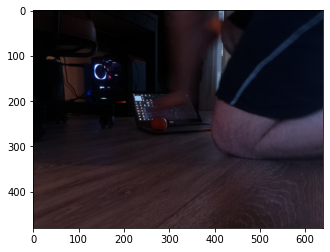

In [ ]:
plt.imshow(image_np)

In [ ]:
idxs = [i for i, x in enumerate(detections['detection_classes']) if category_index[x]['name'] == 'orange']
idxs_scored = [i for i in idxs if detections['detection_scores'][i] >= 0.01]
boxes = [detections['detection_boxes'][i] for i in idxs_scored]

In [ ]:
for b in boxes:
  print(b)

[0.48747444 0.40563247 0.5525655  0.46298167]


In [ ]:
xmin = boxes[0][1] * width
ymin = boxes[0][0] * height
xmax = boxes[0][3] * width
ymax = boxes[0][2] * height

In [ ]:
#ymin,xmin,ymax,xmax - viz utils
#xmin, ymin, xmax, ymax cv2 rectangle
img = cv2.rectangle(image_np, (int(xmin), int(ymin)), (int(xmax),int(ymax)), (125, 255, 51), thickness=2)

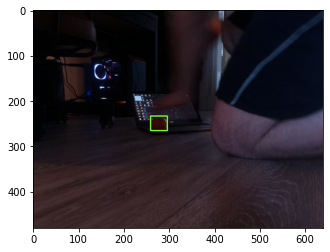

In [ ]:
plt.imshow(img)

In [ ]:
import csv 
from tqdm.notebook import tqdm

def csv_writer(images, cls, score_thresh=0.2):

  data = []
  header = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']

  for img in tqdm(images):
    image_np = load_image_into_numpy_array(img)
    detections = inference(image_np)

    width = image_np.shape[1]
    height = image_np.shape[0]

    idxs = [i for i, x in enumerate(detections['detection_classes']) if category_index[x]['name'] == cls]
    idxs_scored = [i for i in idxs if detections['detection_scores'][i] >= score_thresh]
    boxes = [detections['detection_boxes'][i] for i in idxs_scored]
    
    for b in boxes:
      xmin = b[1] * width
      ymin = b[0] * height
      xmax = b[3] * width
      ymax = b[2] * height

      data.append([os.path.basename(img), width, height, cls, xmin, ymin, xmax, ymax])
  
  with open(f'{cls}.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(data)




In [ ]:
csv_writer(images, 'orange')

  0%|          | 0/366 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

df = pd.read_csv('orange.csv')
df.head()

filename  width  height  ...        ymin        xmax        ymax
0  2019-10-25-12-26-18.jpg    640     480  ...  233.987732  296.308270  265.231447
1  2019-10-25-12-21-10.jpg    640     480  ...  237.040815  306.269417  266.632347
2  2019-10-25-12-27-36.jpg    640     480  ...  229.934406  477.138329  254.887962
3  2019-10-25-12-23-45.jpg    640     480  ...  236.805182  575.367775  262.216873
4  2019-10-23-15-30-58.jpg    640     480  ...  357.833261  428.562469  476.860428

[5 rows x 8 columns]

great and now we have a csv ready to retrain a lightweight architecture!

In [ ]:
len(df)

212

In [ ]:
from random import randrange
import cv2 as cv
from google.colab.patches import cv2_imshow

def plot_annotations(img_base, annotations):
  
  choice = randrange(len(annotations)-1)
  entry =  annotations.iloc[choice]
  img = entry.filename
  mask = annotations.filename == img
  detections = annotations[mask]
  print(img)
  print(detections['class'])



  image = cv.imread(f'{img_base}/{img}')


  for index, row in detections.iterrows():

    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']
    cv.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (125, 255, 51), thickness=2)
    #cv.putText(image,row['class'],(xmin,ymin - 4), cv.FONT_HERSHEY_SIMPLEX , 0.4, (255, 0,0), 1, cv.LINE_AA)

  cv2_imshow(image)

2020-01-10-21-12-51.jpg
167    orange
Name: class, dtype: object


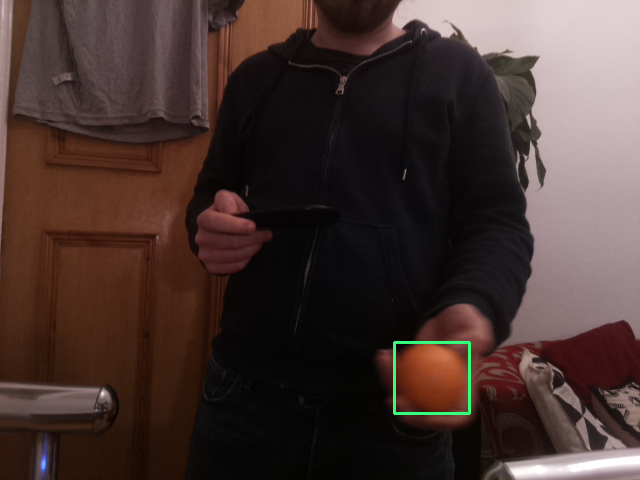

In [ ]:
img_base = '/content/drive/MyDrive/testing_ground/capstone/pictures/'

plot_annotations(img_base, df)

# Challenge!

Now let's see if you can combine both the csv writer and vide inference concept together. Most of the parts you need are within this notebook except for one final step, writing the frame to an appropriate directory ready for training. To recap you'll need to pull off the follwing stops.

- Implement the video writer as we've seen.
- Intercept each frame in the video writer and write the inference results to csv.
- output each frame to a corresponding data directory.
- You should end up with an annotation csv and a dataset corresponding to the filenames per row.

There are several methods of delivery as usual in this case - Either work in a cell, or write to a script with the `%%writefile` magic.

In [ ]:
#your code here

210.png
9    orange
Name: class, dtype: object
/content/train_images/210.png


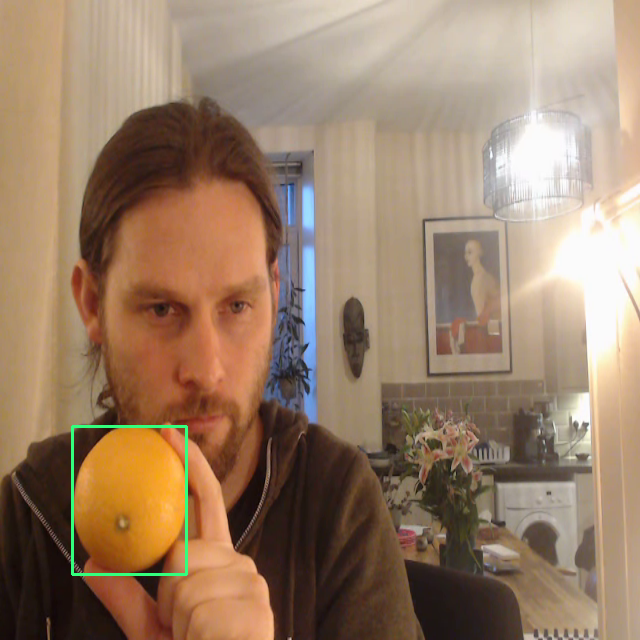

In [ ]:
img_base = '/content/train_images'

plot_annotations(img_base, df)